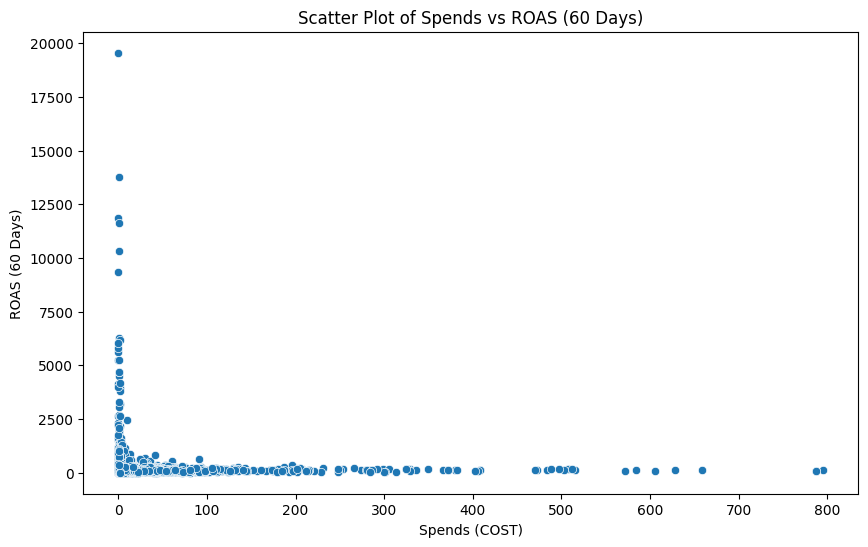

In [3]:
import zipfile
import os
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Путь к файлу базы данных
zip_path = r'./testcase.db.zip'
extract_folder = r'./testcase_db'

# Распаковка файла
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Подключение к базе данных
db_path = os.path.join(extract_folder, 'testcase.db')
conn = sqlite3.connect(db_path)

# Загрузка данных из таблиц costs и revenue
costs_df = pd.read_sql("SELECT * FROM costs", conn)
revenue_df = pd.read_sql("SELECT * FROM revenue", conn)

# Закрытие соединения с базой данных
conn.close()

# Объединение таблиц
merged_df = pd.merge(costs_df, revenue_df, on=['campaign_id', 'Install_Dates', 'Country'])

# Расчет ROAS на 60-й день
merged_df['ROAS_60d'] = (merged_df['60d_LTV'] / merged_df['spends']) * 100

# Фильтрация данных для корреляционного анализа
filtered_df = merged_df[(merged_df['spends'] > 0) & (merged_df['ROAS_60d'] > 0)]

# Визуализация зависимости между расходами и ROAS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='spends', y='ROAS_60d')
plt.title('Scatter Plot of Spends vs ROAS (60 Days)')
plt.xlabel('Spends (COST)')
plt.ylabel('ROAS (60 Days)')
plt.show()

# Расчет корреляции
correlation = filtered_df[['spends', 'ROAS_60d']].corr().iloc[0, 1]

# Расчет CPI
merged_df['CPI'] = merged_df['spends'] / merged_df['installs']

# Фильтрация данных для полиномиальной регрессии
cpi_filtered_df = merged_df[(merged_df['CPI'] > 0) & (merged_df['ROAS_60d'] > 0)]

# Полиномиальная регрессия для CPI
degrees = [2, 3, 4, 5]
cpi_models = {}
for degree in degrees:
    poly_features_cpi = PolynomialFeatures(degree=degree)
    X_cpi_poly = poly_features_cpi.fit_transform(cpi_filtered_df[['CPI']])
    model_cpi = LinearRegression()
    model_cpi.fit(X_cpi_poly, cpi_filtered_df['ROAS_60d'])
    y_cpi_pred = model_cpi.predict(X_cpi_poly)
    r2_cpi = r2_score(cpi_filtered_df['ROAS_60d'], y_cpi_pred)
    cpi_models[degree] = {'model': model_cpi, 'r2': r2_cpi}

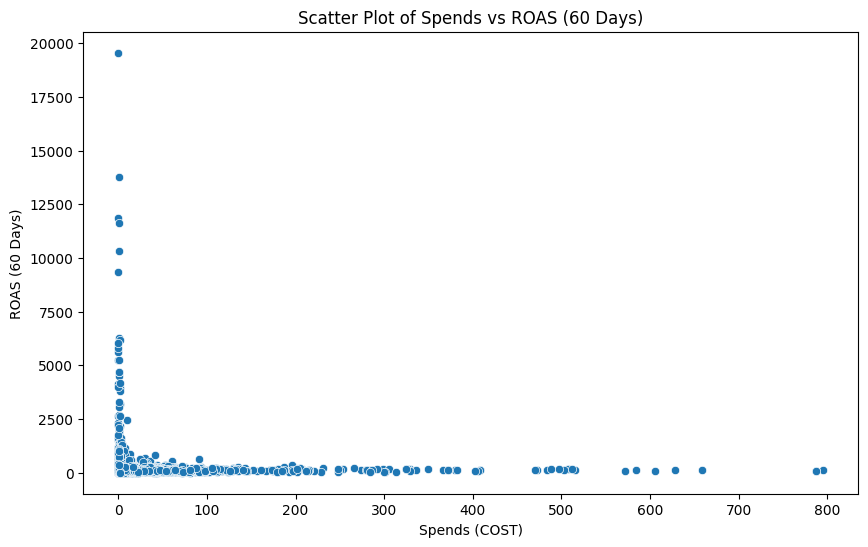

Pearson Correlation Coefficient between COST and ROAS: -0.03783383860459488
Polynomial Degree: 2, R-squared: 0.0051443223826910245
Polynomial Degree: 3, R-squared: 0.006970178524710935
Polynomial Degree: 4, R-squared: 0.008559879155831118
Polynomial Degree: 5, R-squared: 0.010245825712403622


In [6]:
import zipfile
import os
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Путь к файлу базы данных
zip_path = 'testcase.db.zip'
extract_folder = 'testcase_db'

# Распаковка файла
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Подключение к базе данных
db_path = os.path.join(extract_folder, 'testcase.db')
conn = sqlite3.connect(db_path)

# Загрузка данных из таблиц costs и revenue
costs_df = pd.read_sql("SELECT * FROM costs", conn)
revenue_df = pd.read_sql("SELECT * FROM revenue", conn)

# Закрытие соединения с базой данных
conn.close()

# Объединение таблиц
merged_df = pd.merge(costs_df, revenue_df, on=['campaign_id', 'Install_Dates', 'Country'])

# Расчет ROAS на 60-й день
merged_df['ROAS_60d'] = (merged_df['60d_LTV'] / merged_df['spends']) * 100

# Фильтрация данных для корреляционного анализа
filtered_df = merged_df[(merged_df['spends'] > 0) & (merged_df['ROAS_60d'] > 0)]

# Визуализация зависимости между расходами и ROAS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='spends', y='ROAS_60d')
plt.title('Scatter Plot of Spends vs ROAS (60 Days)')
plt.xlabel('Spends (COST)')
plt.ylabel('ROAS (60 Days)')
plt.show()

# Расчет корреляции и вывод результатов
correlation = filtered_df[['spends', 'ROAS_60d']].corr().iloc[0, 1]
print(f'Pearson Correlation Coefficient between COST and ROAS: {correlation}')

# Расчет CPI
merged_df['CPI'] = merged_df['spends'] / merged_df['installs']

# Фильтрация данных для полиномиальной регрессии
cpi_filtered_df = merged_df[(merged_df['CPI'] > 0) & (merged_df['ROAS_60d'] > 0)]

# Полиномиальная регрессия для CPI
degrees = [2, 3, 4, 5]
cpi_models = {}
for degree in degrees:
    poly_features_cpi = PolynomialFeatures(degree=degree)
    X_cpi_poly = poly_features_cpi.fit_transform(cpi_filtered_df[['CPI']])
    model_cpi = LinearRegression()
    model_cpi.fit(X_cpi_poly, cpi_filtered_df['ROAS_60d'])
    y_cpi_pred = model_cpi.predict(X_cpi_poly)
    r2_cpi = r2_score(cpi_filtered_df['ROAS_60d'], y_cpi_pred)
    cpi_models[degree] = {'model': model_cpi, 'r2': r2_cpi}
    print(f'Polynomial Degree: {degree}, R-squared: {r2_cpi}')

In [22]:
# 2

import pandas as pd
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

# Предполагается, что данные из таблиц costs и revenue уже загружены в DataFrame-ы costs_df и revenue_df

# Объединение таблиц
merged_df = pd.merge(costs_df, revenue_df, on=['campaign_id', 'Install_Dates', 'Country'])

# Определение функции для нелинейной регрессии и оптимизации бюджета для каждой кампании
def optimize_budget_nonlinear(campaign_data):
    # Нелинейная модель зависимости дохода от расходов
    def revenue_model(spends, a, b, c):
        return a * spends**2 + b * spends + c

    # Попытка выполнить нелинейную регрессию для оценки параметров модели
    try:
        popt, _ = curve_fit(revenue_model, campaign_data['spends'], campaign_data['60d_LTV'])
    except:
        return None, None

    # Функция прибыли
    def profit(spends):
        return revenue_model(spends, *popt) - spends

    # Оптимизация бюджета для максимизации прибыли
    result = minimize_scalar(lambda x: -profit(x), bounds=(0, campaign_data['spends'].max()), method='bounded')
    if result.success:
        optimized_spends = result.x
        optimized_profit = profit(optimized_spends)
    else:
        optimized_spends = None
        optimized_profit = None

    return optimized_spends, optimized_profit

# Применение оптимизации к каждой кампании
optimized_budgets_nonlinear = {}
campaigns = merged_df['campaign_id'].unique()
for campaign in campaigns:
    campaign_data = merged_df[merged_df['campaign_id'] == campaign]
    optimized_budgets_nonlinear[campaign] = optimize_budget_nonlinear(campaign_data)

# Вывод результатов
optimized_budgets_nonlinear

c:\Users\imom\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{90570: (15.306540100723824, 2.706481589817086),
 90619: (5.564128528253879e-06, 1.9099665220655246),
 794235: (6.0786242416359835e-06, -1.0000060779851059),
 91872: (61.109992246100724, 14.266309773920447),
 19115: (4.645411468051328e-06, -0.7792596012248375),
 790424: (27.522266187264126, 10.347975054154286),
 161569: (48.718404131688644, 12.668521942326244),
 792410: (6.172041846310177e-06, -1.0000061707727101),
 788583: (43.79999499071631, 9.142901967572023),
 789470: (11.653704923486872, 11.219296217196783),
 92492: (0.6599936343820523, 0.04727582439517053),
 92708: (93.46999285984221, 45.314415837854895),
 94342: (6.025646052935207e-06, 0.06957712200966859),
 22083: (6.1259348177332905e-06, -0.5598203478523255),
 95659: (139.33999447320278, 35.34447640348708),
 158519: (4.123656586508681e-06, 1.0183334062575686),
 93619: (5.6070170060482435e-06, 0.789737168080177),
 787112: (5.429378992731485e-06, 3.020835699569498),
 791300: (23.359995919920404, 19.79061197328532),
 160483: (4.3

In [23]:
# 3

# Предполагается, что optimized_budgets_nonlinear содержит оптимальные бюджеты, найденные ранее

# Сравнение оптимальных бюджетов с текущими бюджетами
current_budgets = merged_df.groupby('campaign_id')['spends'].mean()  # Средний текущий бюджет по кампаниям
budget_recommendations = {}

for campaign in campaigns:
    if campaign in optimized_budgets_nonlinear:
        optimal_budget = optimized_budgets_nonlinear[campaign][0] if optimized_budgets_nonlinear[campaign][0] is not None else 0
        current_budget = current_budgets[campaign]
        if optimal_budget > current_budget:
            recommendation = 'Increase'
        elif optimal_budget < current_budget:
            recommendation = 'Decrease'
        else:
            recommendation = 'Maintain'
        budget_recommendations[campaign] = (current_budget, optimal_budget, recommendation)

budget_recommendations

{90570: (16.467857142857145, 15.306540100723824, 'Decrease'),
 90619: (19.38357843137255, 5.564128528253879e-06, 'Decrease'),
 794235: (0.08720620842572062, 6.0786242416359835e-06, 'Decrease'),
 91872: (16.973559322033896, 61.109992246100724, 'Increase'),
 19115: (18.335215805471126, 4.645411468051328e-06, 'Decrease'),
 790424: (14.802000000000001, 27.522266187264126, 'Increase'),
 161569: (23.527884615384615, 48.718404131688644, 'Increase'),
 792410: (2.307523510971787, 6.172041846310177e-06, 'Decrease'),
 788583: (15.481904761904762, 43.79999499071631, 'Increase'),
 789470: (7.803571428571429, 11.653704923486872, 'Increase'),
 92492: (0.31142857142857144, 0.6599936343820523, 'Increase'),
 92708: (30.248688524590165, 93.46999285984221, 'Increase'),
 94342: (9.539117647058823, 6.025646052935207e-06, 'Decrease'),
 22083: (16.40096401384083, 6.1259348177332905e-06, 'Decrease'),
 95659: (56.63640625, 139.33999447320278, 'Increase'),
 158519: (13.3176, 4.123656586508681e-06, 'Decrease'),
 

In [29]:
# 4
from datetime import datetime

# Подключение к базе данных
db_path = os.path.join(extract_folder, 'testcase.db')
conn = sqlite3.connect(db_path)

# Загрузка данных из таблиц costs и revenue
costs_df = pd.read_sql("SELECT * FROM costs", conn)
revenue_df = pd.read_sql("SELECT * FROM revenue", conn)

# Закрытие соединения с базой данных
conn.close()

# Объединение таблиц
merged_df = pd.merge(costs_df, revenue_df, on=['campaign_id', 'Install_Dates', 'Country'])
merged_df['Install_Dates'] = pd.to_datetime(merged_df['Install_Dates'])
current_date = datetime.now()
merged_df['days_since_install'] = (current_date - merged_df['Install_Dates']).dt.days

# Проверка наличия кампаний с длительностью менее 60 дней
has_incomplete_campaigns = merged_df['days_since_install'].lt(60).any()
has_incomplete_campaigns

False